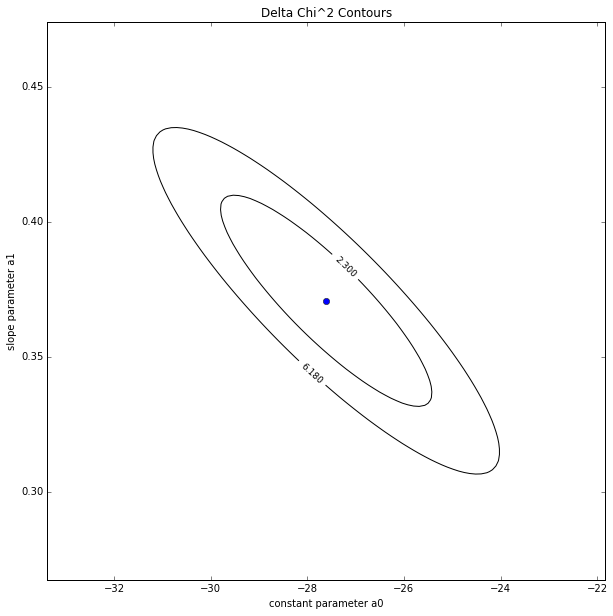

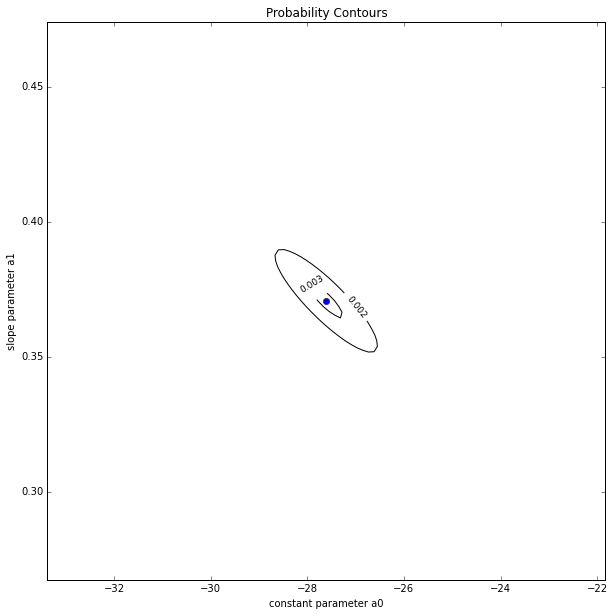

In [141]:
"""
         1         2         3         4         5         6         7      
1234567890123456789012345678901234567890123456789012345678901234567890123456
"""

"""
Cordell Newmiller
Prof. Fassnacht
PHY 266
Homework 5
Problem 2


In the previous homework, you solved for σa0 and σa1 when fitting to the 
xy_fitting.txt data set. Here we are going to explore the two-dimensional 
confidence regions. We are going to explore the region defined by 
ˆa0 − 4σa0 < a0 < aˆ0 + 4σa0 and ˆa1 −4σa1 < a1 < aˆ1 + 4σa1. 
Make a 100x99 grid in this 2D parameter space. Why not 100x100? Because of 
the way that python handles vectors, it may not be completely obvious at a 
later stage whether your marginalization has created an a0 PDF or an a1 PDF.
By having different sizes along the two axes, you can make sure that you 
have gotten the right PDF with each parameter.


(a) Calculate χ2 for each point on your 100x99 grid, i.e., create a 2D χ2 
distribution. Note that for this step, the use of the numpy meshgrid 
function will make things easier. Then create a ∆χ2 distribution by 
subtracting the value of χ2 that you found in the previous homework. 
Finally plot contours of ∆χ2 = 2.3 and ∆χ2 = 6.18. What do these two values
represent? See the contour plotting help (google “matplotlib contour” and 
choose the “contour demo.py” link to see both how to plot contours and how 
to use meshgrid).

"""
import numpy
import CJN_Functions as my
from matplotlib import pyplot
%matplotlib inline

# Assumes the file is in the working directory
data=numpy.loadtxt('xy_fitting.txt')
xdata=data[:,0]
ydata=data[:,1]
ysigmas=numpy.zeros(ydata.shape)+5.0

# Calls the results of the last homework. (PolynomialFit is a generalized 
# version of hw4p2, see the CJN_Function file for details.) 
ymodel,parameters,psigmas,chisquared,reducedchisquared = (
    my.PolynomialFit(xdata,ydata,ysigmas,2))

# Build the parameter space
a0range = numpy.linspace(parameters[0]-4*psigmas[0],
                        parameters[0]+4*psigmas[0], 100)
a1range = numpy.linspace(parameters[1]-4*psigmas[1],
                        parameters[1]+4*psigmas[1], 99)
mesh0,mesh1 = numpy.meshgrid(a0range,a1range)

# Modelgrid is a 3D matrix, with ymodel estimates for each pair of a0,a1
modelgrid = (mesh0[numpy.newaxis,:,:] + numpy.multiply.outer(xdata,mesh1))

# DeltaChiGrid is a 2D matrix of ∆χ2 values 
chisquaredgrid,_ = (my.ChiSquare(modelgrid,ydata[:,numpy.newaxis,
                numpy.newaxis],ysigmas[:,numpy.newaxis,numpy.newaxis],2))
deltachigrid = chisquaredgrid - chisquared


levels=numpy.array([2.3,6.18])

figure1 = pyplot.figure(figsize=(10,10));
pyplot.plot(parameters[0],parameters[1],'o')
contours = pyplot.contour(mesh0,mesh1,deltachigrid,levels,colors="k")
pyplot.title("Delta Chi^2 Contours")
pyplot.clabel(contours,fontsize=9,inline=1)
pyplot.xlabel("constant parameter a0")
pyplot.ylabel("slope parameter a1")


"""
(b) Now calculate the posterior probability for each point on your 2D grid 
of a0 and a1. You can assume uninformative priors for each parameter – just 
state what your priors are. Remember that you will have to normalize the 
values in order to make them correspond to probabilities, but you can do by
first just doing P(model|data) ∝ P(data|model) P(model) and then summing 
over the values you obtained, as we discussed in class. State the values of
the normalized posterior that correspond to 68 and 95.4% confidence regions.
NOTE: Use the values that you have derived for the normalized posterior 
itself to determine these values. Do NOT use ∆χ2 values to determine the 
confidence regions. Plot contours at these levels. How does this plot 
compare to your ∆χ2 plot? 
Hint: The numpy cumsum function may be helpful here.
"""

# To assume uninformative priors, assume the priors are uniform over the 
# parameter space spanned, and zero outside that space.

# This is from page 129 in Wall
liklihoods=numpy.exp(-chisquaredgrid/2**0.5)

probabilities=liklihoods/numpy.sum(liklihoods)


probabilitylist=numpy.sort(numpy.ndarray.flatten(probabilities))
cumulativelist=numpy.cumsum(probabilitylist)

limits=numpy.array(([0.68,0.954]))

indices=numpy.sum(cumulativelist[:,numpy.newaxis]
                  <limits[numpy.newaxis,:],0)

plevels=probabilitylist[indices]

# Debugging
# print(modelgrid.shape,numpy.sum(probabilities),numpy.shape(liklihoods))
# print(indices,plevels,numpy.max(probabilities),cumulativelist[indices])

figure2 = pyplot.figure(figsize=(10,10));
pyplot.plot(parameters[0],parameters[1],'o')
contours = pyplot.contour(mesh0,mesh1,probabilities,plevels,colors="k")
pyplot.title("Probability Contours")
pyplot.clabel(contours,fontsize=9,inline=1)
pyplot.xlabel("constant parameter a0")
pyplot.ylabel("slope parameter a1")

∆χ2: ∆χ2=1 confidence regions
a0 is -27.61 ± 1.34
a1 is 0.37 ± 0.03
Probability: 68% confidence regions
a0 is -27.61 ± 1.23
a1 is 0.37 ± 0.02


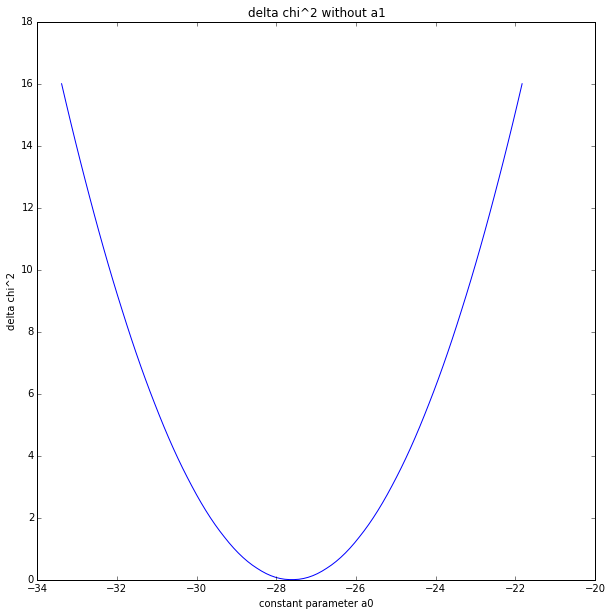

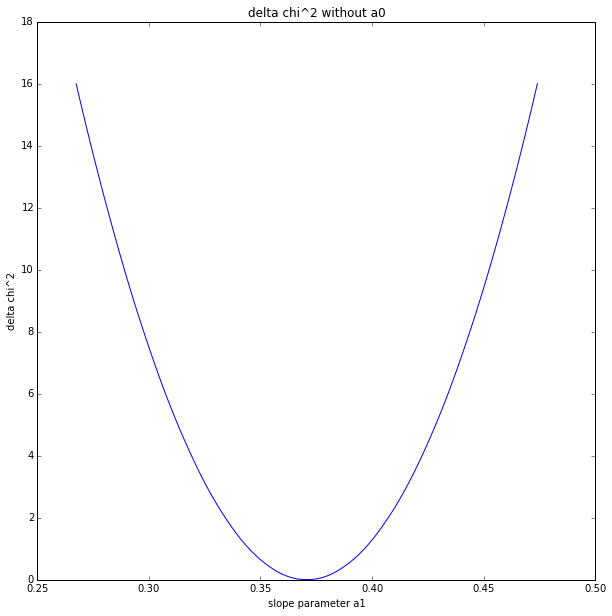

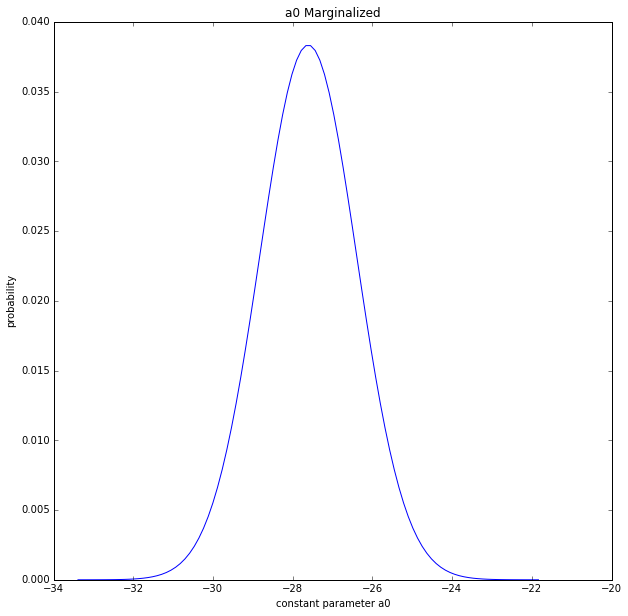

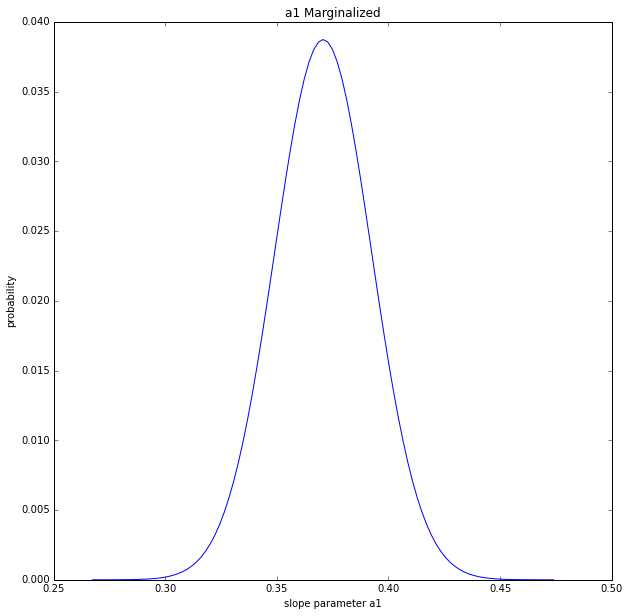

In [144]:
"""
         1         2         3         4         5         6         7      
1234567890123456789012345678901234567890123456789012345678901234567890123456
"""

"""
Cordell Newmiller
Prof. Fassnacht
PHY 266
Homework 5
Problem 3


(a) In class we discussed the fact that, if we want the uncertainties of 
fewer parameters than are included in the fit, we have to project the χ2
surface onto the smaller dimensional region corresponding to the parameters 
of interest. In this problem, we will use the results of the previous 
problem to go from 2 dimensions to 1 dimension. Let’s say that you want to 
find the confidence region for a0. In class, I gave a prescription for 
doing this projection, which boiled down to something like the following:

• Find your best fit parameters for the full parameter set, ~aˆ.
• Change a0 to something other than its best fit value, call this a0,i, 
then hold it fixed at a0,i and vary all of the other parameters to 
minimize χ2.
• Repeat for a series of different values of a0,i to get a projected χ2 
curve.
• After doing this, your 1-dimensional confidence regions can be defined 
by, e.g., ∆χ2 =1, 4, or 9 for the nominal 1σ, 2σ, or 3σ regions. 

This process is made easy because you already have done all of the 
computation in the previous problem, in particular by calculating the 
values in the ∆χ2 array. To do the projection, just find, for each value 
of a0, the minimum value of ∆χ2 in the row corresponding to that value. Now:

1. Plot the projected ∆χ2 curves for a0 and a1. Note that if you have done 
the projections correctly, the lengths of the curves will match the 
lengths of your parameter vectors (either 99 or 100 elements).
2. Calculate the confidence regions on a0 and a1 corresponding to ∆χ2=1. 
Compare to the values you found from the covariance matrix in the linear 
fit.
"""

# Running this in the same notebook as problem 2, to use the grids
# calculated in that problem.

#import numpy
#from matplotlib import pyplot
#%matplotlib inline
#import a0range, a1range, deltachigrid, and probabilities from CJNhw5p2

# Distribution of a0, with ∆χ2 minimized for each a1
a0chidist=numpy.min(deltachigrid,0)
a1chidist=numpy.min(deltachigrid,1)
# Sanity check on lengths: they'll need to match a0range and a1range in 
# order to plot successfully.


figure3 = pyplot.figure(figsize=(10,10));
pyplot.plot(a0range,a0chidist)
pyplot.xlabel("constant parameter a0")
pyplot.ylabel("delta chi^2")
pyplot.title("delta chi^2 without a1")

figure4 = pyplot.figure(figsize=(10,10));
pyplot.plot(a1range,a1chidist)
pyplot.xlabel("slope parameter a1")
pyplot.ylabel("delta chi^2")
pyplot.title("delta chi^2 without a0")

# ∆χ2=1 confidence regions, assuming symmetric Gaussian
print("∆χ2: ∆χ2=1 confidence regions")
a0dev=parameters[0]-(a0range[(a0chidist <= 1)])[0]
print("a0 is %2.2f ± %2.2f" % (parameters[0],a0dev))
a1dev=parameters[1]-(a1range[(a1chidist <= 1)])[0]
print("a1 is %2.2f ± %2.2f" % (parameters[1],a1dev))


"""
(b) Here we are going to do the same kind of process, but by marginalizing
the posterior probability array that you found in the previous problem. To 
get the 1-dimensional PDFs, just sum along the columns and rows. For a0 and
a1 do the following:
1. Plot the 1-dimensional marginalized PDFs.
2. Determine from the PDFs the 68% confidence regions. Remember that using 
the CDF can make this simple.
"""

a0probdist=numpy.sum(probabilities,0)
a1probdist=numpy.sum(probabilities,1)

figure5 = pyplot.figure(figsize=(10,10));
pyplot.plot(a0range,a0probdist)
pyplot.xlabel("constant parameter a0")
pyplot.ylabel("probability")
pyplot.title("a0 Marginalized")

figure6 = pyplot.figure(figsize=(10,10));
pyplot.plot(a1range,a1probdist)
pyplot.xlabel("slope parameter a1")
pyplot.ylabel("probability")
pyplot.title("a1 Marginalized")

# 68% confidence regions, assuming symmetric Gaussian
print("Probability: 68% confidence regions")
a0pdev=parameters[0]-(a0range[numpy.cumsum(a0probdist) >= .16])[0]
print("a0 is %2.2f ± %2.2f" % (parameters[0],a0pdev))
a1pdev=parameters[1]-(a1range[numpy.cumsum(a1probdist) >= .16])[0]
print("a1 is %2.2f ± %2.2f" % (parameters[1],a1pdev))

# End of problem 3